In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose


In [2]:
# set seed for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

**Data Overview**

In [3]:
data = datasets.MNIST(root = "data", download = True)
print(len(data))

60000


In [4]:
label_data = [data[i][1] for i in range(len(data))]
print(Counter(label_data))

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


We have 10 labels (10 classes) 0-9 for ten digits 0-9. There exists the imbalance between labels.

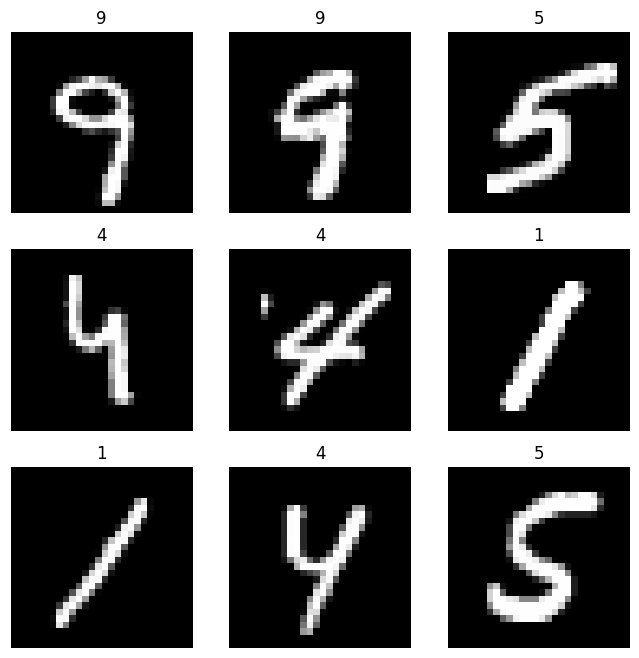

In [5]:
# Visualize some datapoints 
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
for i in range(1, cols * rows + 1):
    plt.axis("off")
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

Since Pytorch can not work directly with images, we need to transform the images to tensor

**Load Data**

In [6]:
# Define cpu or gpu device for training  
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
# Download training data 
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

# Download test data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

**Normalization**

In [8]:
# Calculation pixels mean and standard deviation of train data
img_list = [train_data[i][0] for i in range(len(train_data))]
img_list = torch.vstack((img_list))
train_mean = img_list.mean()
train_std = img_list.std()
print("Pixels mean of train data:", train_mean)
print("Pixels standard deviation of train data:", train_std)

Pixels mean of train data: tensor(0.1307)
Pixels standard deviation of train data: tensor(0.3081)


In [9]:
# define a transformer for train and test data
# define a transformer
transformer = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

# Load train data with normalization
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transformer
    )

# Load train data with normalization
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transformer
)

In [10]:
# Check train data after nomalization
img_list = [train_data[i][0] for i in range(len(train_data))]
img_list = torch.vstack((img_list))
train_mean = img_list.mean()
train_std = img_list.std()
print("Pixels mean of train data after normalization:", train_mean)
print("Pixels standard deviation of train data after normalization:", train_std)

# Check test data after nomalization
img_list = [test_data[i][0] for i in range(len(test_data))]
img_list = torch.vstack((img_list))
test_mean = img_list.mean()
test_std = img_list.std()
print("Pixels mean of test data after normalization:", test_mean)
print("Pixels standard deviation of test data after normalization:", test_std)

Pixels mean of train data after normalization: tensor(-0.0001)
Pixels standard deviation of train data after normalization: tensor(1.0000)
Pixels mean of test data after normalization: tensor(0.0059)
Pixels standard deviation of test data after normalization: tensor(1.0077)


#### Data Preparation

In [11]:
# Creating train and test batches with batch size = 64
train_dataloader = DataLoader(train_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)

In [12]:
len(train_dataloader)

938

The number of batches for training is 938, the size of each batch is 64. Then we create functions for train and test model

In [13]:
# train function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # total size of the train set 
    num_batch = len(dataloader)  # number of batches
    model.train()  # training mode

    total_loss = 0  # total loss
    total_correct = 0  # total correct predictions of the dataset
    
    batch_loss = {}  # loss of each batch
    batch_accuracy = {}  # accuracy of each batch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        batch_loss[batch] = loss.item()
        total_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy 
        batch_correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        batch_accuracy[batch] = batch_correct/len(X)
        total_correct += batch_correct
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    # Calculate the train accuracy and average loss
    train_accuracy = total_correct/size
    avg_loss = total_loss/num_batch

    print("Train Error:")
    print(f" Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {avg_loss:>8f}")

    return batch_loss, batch_accuracy, train_accuracy, avg_loss


In [14]:
# test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)  # total size of the test set 
    num_batch = len(dataloader)  # number of batches
    model.eval()  # test mode

    total_loss = 0  # total loss
    total_correct = 0  # total correct predictions of the dataset
    
    batch_loss = {}  # loss of each batch
    batch_accuracy = {}  # accuracy of each batch

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            batch_loss[batch] = loss.item()
            total_loss += loss

            # Compute accuracy 
            batch_correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
            batch_accuracy[batch] = batch_correct/len(X)
            total_correct += batch_correct
            
    # Calculate the test accuracy and average loss
    test_accuracy = total_correct/size
    avg_loss = total_loss/num_batch

    print("Test Error:")
    print(f" Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {avg_loss:>8f}")

    return batch_loss, batch_accuracy, test_accuracy, avg_loss    

We create a function to train and test model. The step_decay is for enabling the step decreasing of learning rate after the number of epochs

In [15]:
# Function to train and test model
def train_test_epoch(train_dataloader, test_dataloader, model, loss_func, optimizer, epochs = 10, step_decay = False):
  train_batch_loss = []
  train_batch_accuracy = []
  test_batch_loss = []
  test_batch_accuracy = []

  train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []

  train_epoch = []  # contains train epoch no.
  test_epoch = []  # contains test epoch no.

  if step_decay:
    # Set the step size and gamma for step decay of 
    step_size = 1  # Number of epochs after which to reduce the learning rate
    gamma = 0.1     # Factor by which to reduce the learning rate

    # Create a learning rate scheduler
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

  # Train and test loop
  for epoch in range(epochs):
      print(f"Epoch {epoch+1}\n--------------------------------")
      _train_batch_loss, _train_batch_accuracy, _train_accuracy , _train_loss = train(train_dataloader, model, loss_func, optimizer)
      _test_batch_loss, _test_batch_accuracy, _test_accuracy , _test_loss = test(test_dataloader, model, loss_func)

      for i in range(len(_train_batch_loss)):
          train_batch_loss.append(_train_batch_loss[i])
          train_batch_accuracy.append(_train_batch_accuracy[i])
          train_epoch.append(epoch + float((i+1)/len(_train_batch_loss)))

      for i in range(len(_test_batch_loss)):
          test_batch_loss.append(_test_batch_loss[i])
          test_batch_accuracy.append(_test_batch_accuracy[i])
          test_epoch.append(epoch + float((i+1)/len(_test_batch_loss)))

      train_accuracy.append(_train_accuracy)
      train_loss.append(_train_loss)
      test_accuracy.append(_test_accuracy)
      test_loss.append(_test_loss)

      if step_decay:
        scheduler.step()

  return train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss

We also create functions to plot graphs

In [16]:
# Functions to plot graphs
def plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss):
    figure = plt.figure(figsize=(12, 12))

    figure.add_subplot(2, 2, 1)
    plt.plot(train_epoch, train_batch_loss)
    plt.title("Train Batch loss")
    plt.xlabel("Epochs") 
    plt.ylabel("Train loss") 

    figure.add_subplot(2, 2, 2)
    plt.plot(train_epoch, train_batch_accuracy)
    plt.title("Train Batch accuracy")
    plt.xlabel("Epochs") 
    plt.ylabel("Train accuracy") 

    figure.add_subplot(2, 2, 3)
    plt.plot(test_epoch, test_batch_loss)
    plt.title("Test Batch loss")
    plt.xlabel("Epochs") 
    plt.ylabel("Test loss") 

    figure.add_subplot(2, 2, 4)
    plt.plot(test_epoch, test_batch_accuracy)
    plt.title("Test Batch accuracy")
    plt.xlabel("Epochs") 
    plt.ylabel("Test accuracy") 

    plt.show()

def plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10):
    fig = plt.figure(figsize=(12, 12))

    fig.add_subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_accuracy, label = "Training accuracy")
    plt.plot(range(1, epochs+1), test_accuracy, label = "Test accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs") 
    plt.ylabel("Accuracy")
    plt.legend()

    fig.add_subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), [tensor.item() for tensor in train_loss], label = "Training loss")
    plt.plot(range(1, epochs+1), [tensor.item() for tensor in test_loss], label = "Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs") 
    plt.ylabel("Loss")
    plt.legend()

**1. Simple Neural Network with one hidden layer**

First experiment with a simple Neural Network with 1 hidden layer and the output layer having 10 nodes for 10 labels. The hidden layer contains 64 nodes and the activation function of that hidden layer is Relu. The activation function at output layer is softmax function to compute probabilities of each class and the loss function is the cross-entropy function. Before going in the hidden layer, there is a flatten layer to transform the image tensor 1x28x28 to a vector with the length 28*28 = 784.

In [17]:
class NN_one(nn.Module):
    def __init__(self):
        super(NN_one, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            ## No need of softmax layer because the loss function defined by nn.CrossEntropyLoss() included the softmax function (pytorch document) 
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

nn_one = NN_one().to(device)
print(nn_one)

NN_one(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [18]:
# Define the loss function and optimizer
loss_func = nn.CrossEntropyLoss()

# Optimizer: ADAM with learning rate = 0.001
optimizer = optim.Adam(nn_one.parameters(), lr=1e-3)

In [19]:
# train and test model
train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss = train_test_epoch(train_dataloader,
                                                                                                  test_dataloader,
                                                                                                  nn_one,
                                                                                                  loss_func,
                                                                                                  optimizer,
                                                                                                  epochs=10,
                                                                                                  step_decay=False)

Epoch 1
--------------------------------
loss: 2.324901 [    0/60000]


loss: 0.296190 [ 6400/60000]
loss: 0.272605 [12800/60000]
loss: 0.255571 [19200/60000]
loss: 0.160784 [25600/60000]
loss: 0.343265 [32000/60000]
loss: 0.142884 [38400/60000]
loss: 0.394123 [44800/60000]
loss: 0.288276 [51200/60000]
loss: 0.250340 [57600/60000]
Train Error:
 Accuracy: 90.9%, Avg loss: 0.319656
Test Error:
 Accuracy: 93.8%, Avg loss: 0.197023
Epoch 2
--------------------------------
loss: 0.116752 [    0/60000]
loss: 0.152717 [ 6400/60000]
loss: 0.087308 [12800/60000]
loss: 0.161491 [19200/60000]
loss: 0.086911 [25600/60000]
loss: 0.248878 [32000/60000]
loss: 0.104544 [38400/60000]
loss: 0.256351 [44800/60000]
loss: 0.195207 [51200/60000]
loss: 0.206675 [57600/60000]
Train Error:
 Accuracy: 95.3%, Avg loss: 0.157387
Test Error:
 Accuracy: 95.6%, Avg loss: 0.143464
Epoch 3
--------------------------------
loss: 0.091554 [    0/60000]
loss: 0.120713 [ 6400/60000]
loss: 0.078751 [12800/60000]
loss: 0.097397 [19200/60000]
loss: 0.042236 [25600/60000]
loss: 0.180637 [32000/60

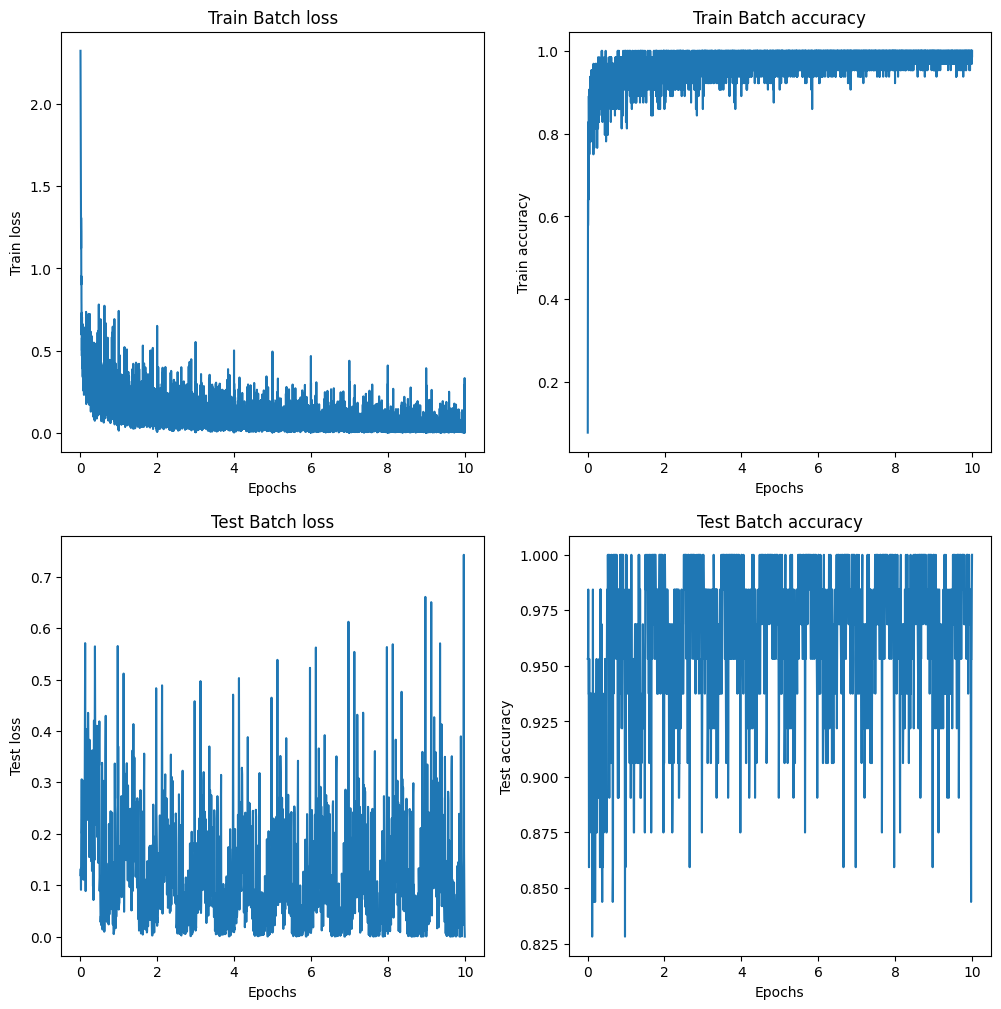

In [20]:
plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss)

Regarding the graphs for train data, the loss decrease quickly and the accuracy increase quickly when the number of epochs increases. Therefore, the **learning rate = 0.001** is resonable.

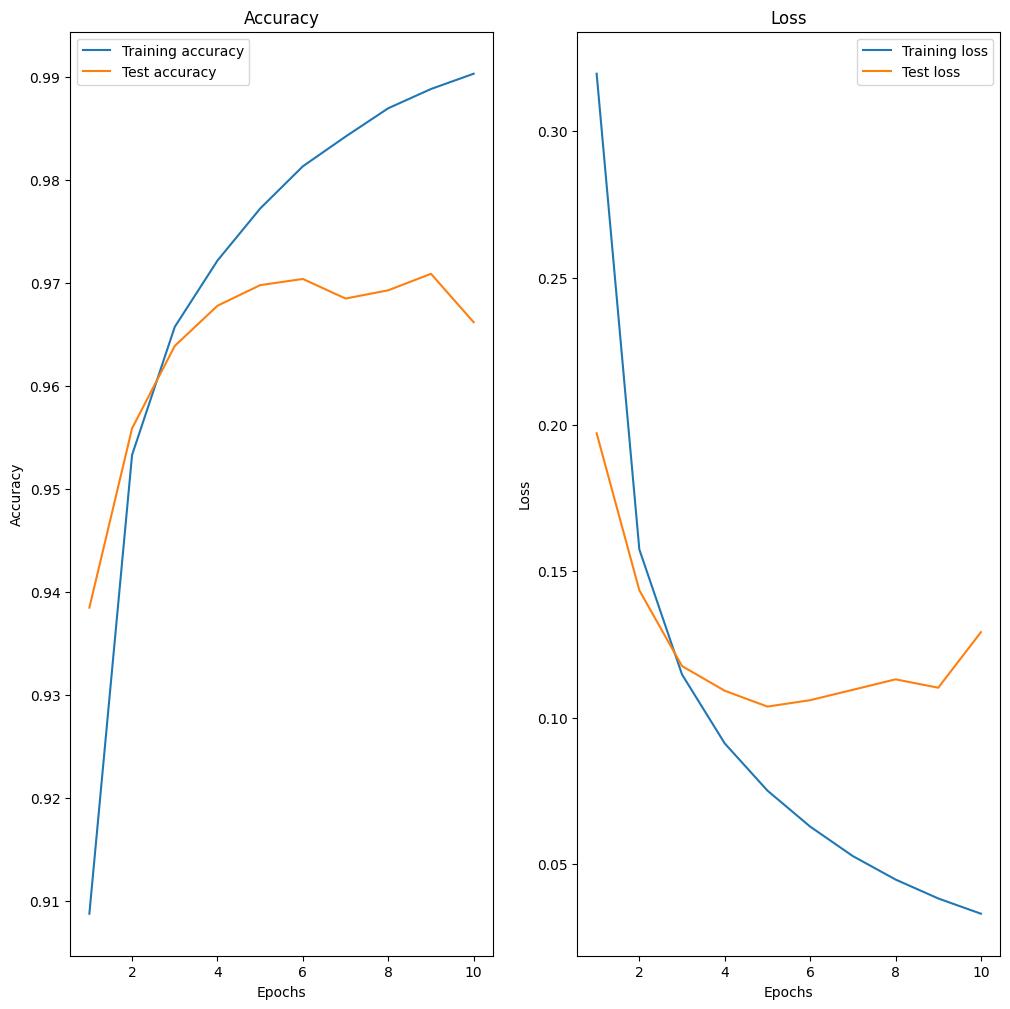

In [21]:
plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10)

It seems that this neural network with one hidden layer has quite high accuracy. However, on the test data, the accuracy does not increase significantly from epoch 4 onwards and from epoch 5 onwards, the loss tends to increase again. This shows that the model is overfitting from epoch 5 onwards (the test loss started to increase).

**2.Neural Network (2 hidden layers) with activation ReLU**

The Neural Network has 2 hidden layers and the output layer having 10 nodes for 10 labels. The first hidden layer contains 128 nodes, the second hidden layer contains 64 nodes. The activation function of hidden layers is Relu. The activation function at output layer is softmax function to compute probabilities of each class and the loss function is the cross-entropy function. Before going in the first hidden layer, there is a flatten layer to transform the image tensor 1x28x28 to a vector with the length 28*28 = 784.

In [23]:
# Define the neural network model
class NN_relu(nn.Module):
    def __init__(self):
        super(NN_relu, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
nn_relu = NN_relu().to(device)
print(nn_relu)

NN_relu(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [24]:
# Optimizer: ADAM with learning rate = 0.001
optimizer1 = optim.Adam(nn_relu.parameters(), lr=1e-3)

# train and test model
train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss = train_test_epoch(train_dataloader,
                                                                                                  test_dataloader,
                                                                                                  nn_relu,
                                                                                                  loss_func,
                                                                                                  optimizer1,
                                                                                                  epochs=10,
                                                                                                  step_decay=False)

Epoch 1
--------------------------------
loss: 2.289867 [    0/60000]


loss: 0.287352 [ 6400/60000]
loss: 0.238614 [12800/60000]
loss: 0.229497 [19200/60000]
loss: 0.140207 [25600/60000]
loss: 0.285712 [32000/60000]
loss: 0.118755 [38400/60000]
loss: 0.307763 [44800/60000]
loss: 0.307549 [51200/60000]
loss: 0.221880 [57600/60000]
Train Error:
 Accuracy: 91.5%, Avg loss: 0.287480
Test Error:
 Accuracy: 94.9%, Avg loss: 0.161625
Epoch 2
--------------------------------
loss: 0.118734 [    0/60000]
loss: 0.141348 [ 6400/60000]
loss: 0.103675 [12800/60000]
loss: 0.110395 [19200/60000]
loss: 0.093006 [25600/60000]
loss: 0.163018 [32000/60000]
loss: 0.076448 [38400/60000]
loss: 0.253691 [44800/60000]
loss: 0.206398 [51200/60000]
loss: 0.214339 [57600/60000]
Train Error:
 Accuracy: 96.3%, Avg loss: 0.123790
Test Error:
 Accuracy: 96.4%, Avg loss: 0.105675
Epoch 3
--------------------------------
loss: 0.071379 [    0/60000]
loss: 0.082541 [ 6400/60000]
loss: 0.080576 [12800/60000]
loss: 0.053482 [19200/60000]
loss: 0.044922 [25600/60000]
loss: 0.071189 [32000/60

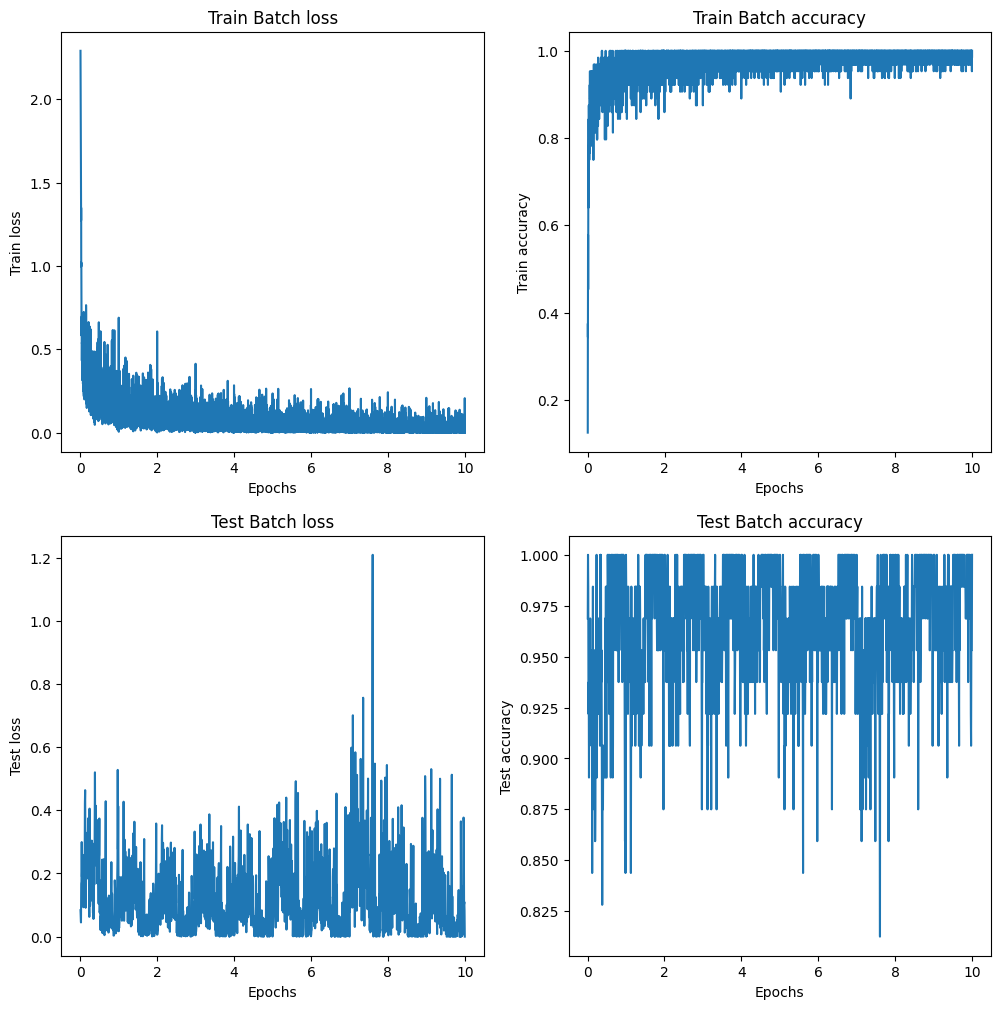

In [25]:
plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss)

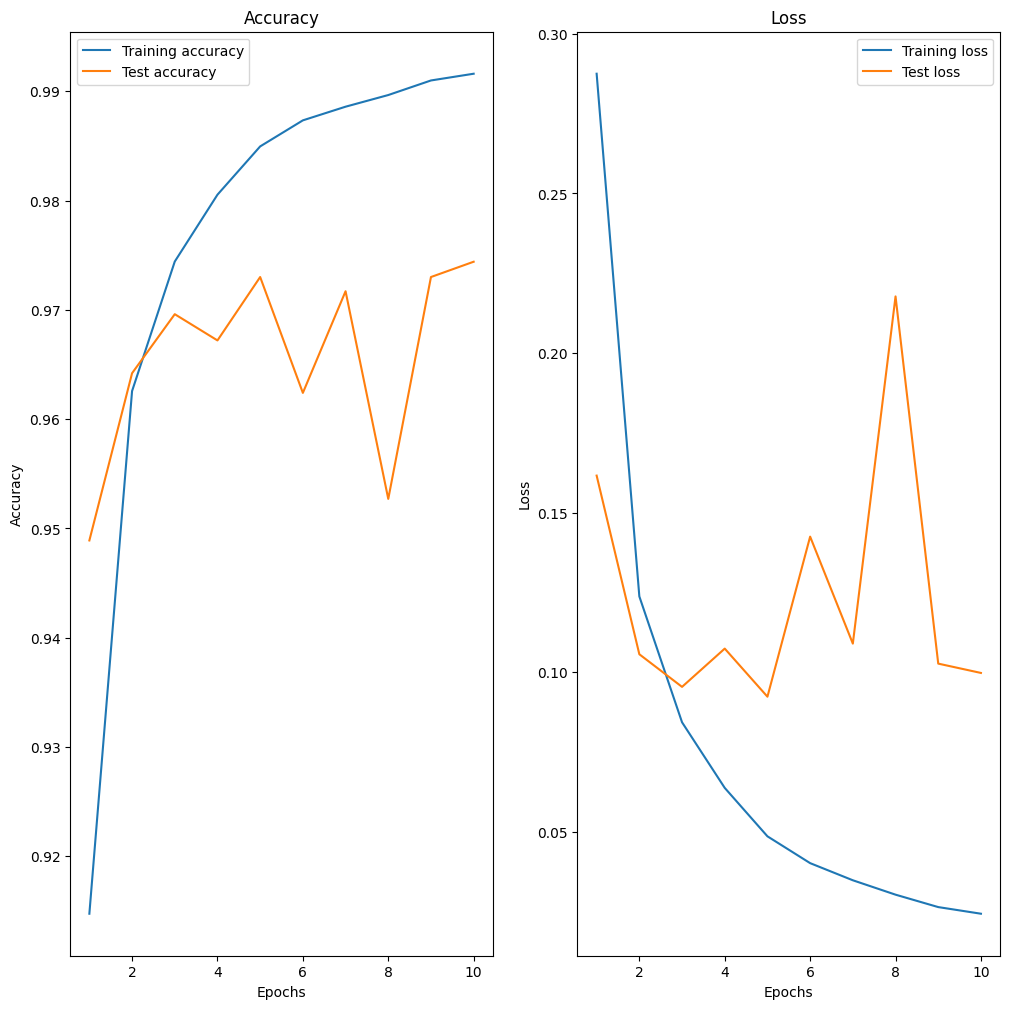

In [27]:
plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10)

The neural network with 2 hidden layers could achieve the higher accuracy (> 0.97) and lower loss (< 0.1) compared to the neural network with one hidden layer. However, from the epoch 5 onwards, the model seems to be overfitting since the test loss started to increase.

**3. Neural Network with activation tanh**

Experiment with the same Neural Network architecture but using Tanh as activation function instead of ReLU

In [29]:
# Define the neural network model
class NN_tanh(nn.Module):
    def __init__(self):
        super(NN_tanh, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_tanh_stack(x)
        return logits
    
nn_tanh = NN_tanh().to(device)
print(nn_tanh)

NN_tanh(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [30]:
# Optimizer: ADAM with learning rate = 0.001
optimizer2 = optim.Adam(nn_tanh.parameters(), lr=1e-3)

# train and test model
train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss = train_test_epoch(train_dataloader,
                                                                                                  test_dataloader,
                                                                                                  nn_tanh,
                                                                                                  loss_func,
                                                                                                  optimizer2,
                                                                                                  epochs=10,
                                                                                                  step_decay=False)

Epoch 1
--------------------------------
loss: 2.304088 [    0/60000]


loss: 0.344947 [ 6400/60000]
loss: 0.259025 [12800/60000]
loss: 0.254147 [19200/60000]
loss: 0.191903 [25600/60000]
loss: 0.261442 [32000/60000]
loss: 0.158319 [38400/60000]
loss: 0.225155 [44800/60000]
loss: 0.247527 [51200/60000]
loss: 0.192267 [57600/60000]
Train Error:
 Accuracy: 91.9%, Avg loss: 0.293481
Test Error:
 Accuracy: 95.4%, Avg loss: 0.149948
Epoch 2
--------------------------------
loss: 0.068773 [    0/60000]
loss: 0.136388 [ 6400/60000]
loss: 0.095296 [12800/60000]
loss: 0.126757 [19200/60000]
loss: 0.076493 [25600/60000]
loss: 0.085065 [32000/60000]
loss: 0.088045 [38400/60000]
loss: 0.186484 [44800/60000]
loss: 0.182349 [51200/60000]
loss: 0.145175 [57600/60000]
Train Error:
 Accuracy: 96.4%, Avg loss: 0.122037
Test Error:
 Accuracy: 96.6%, Avg loss: 0.112504
Epoch 3
--------------------------------
loss: 0.069127 [    0/60000]
loss: 0.148143 [ 6400/60000]
loss: 0.095777 [12800/60000]
loss: 0.078913 [19200/60000]
loss: 0.053417 [25600/60000]
loss: 0.079364 [32000/60

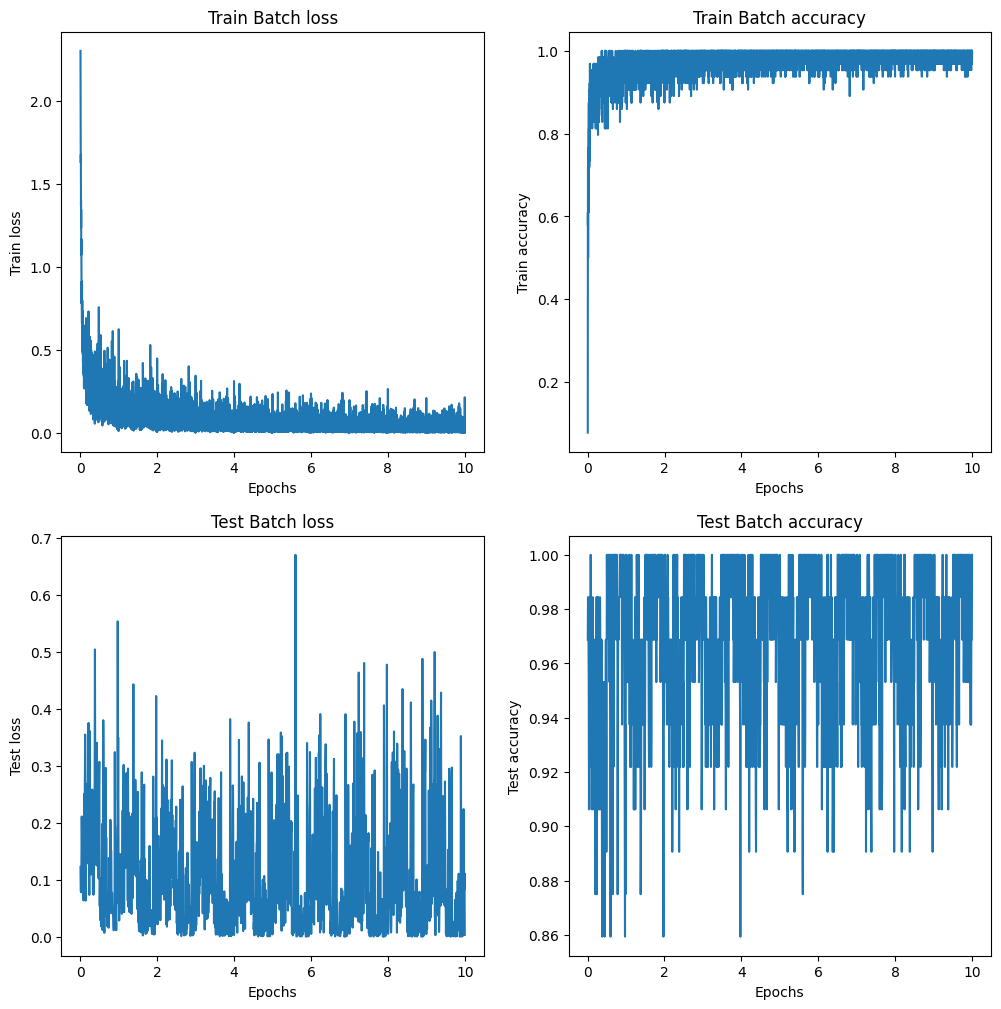

In [31]:
plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss)

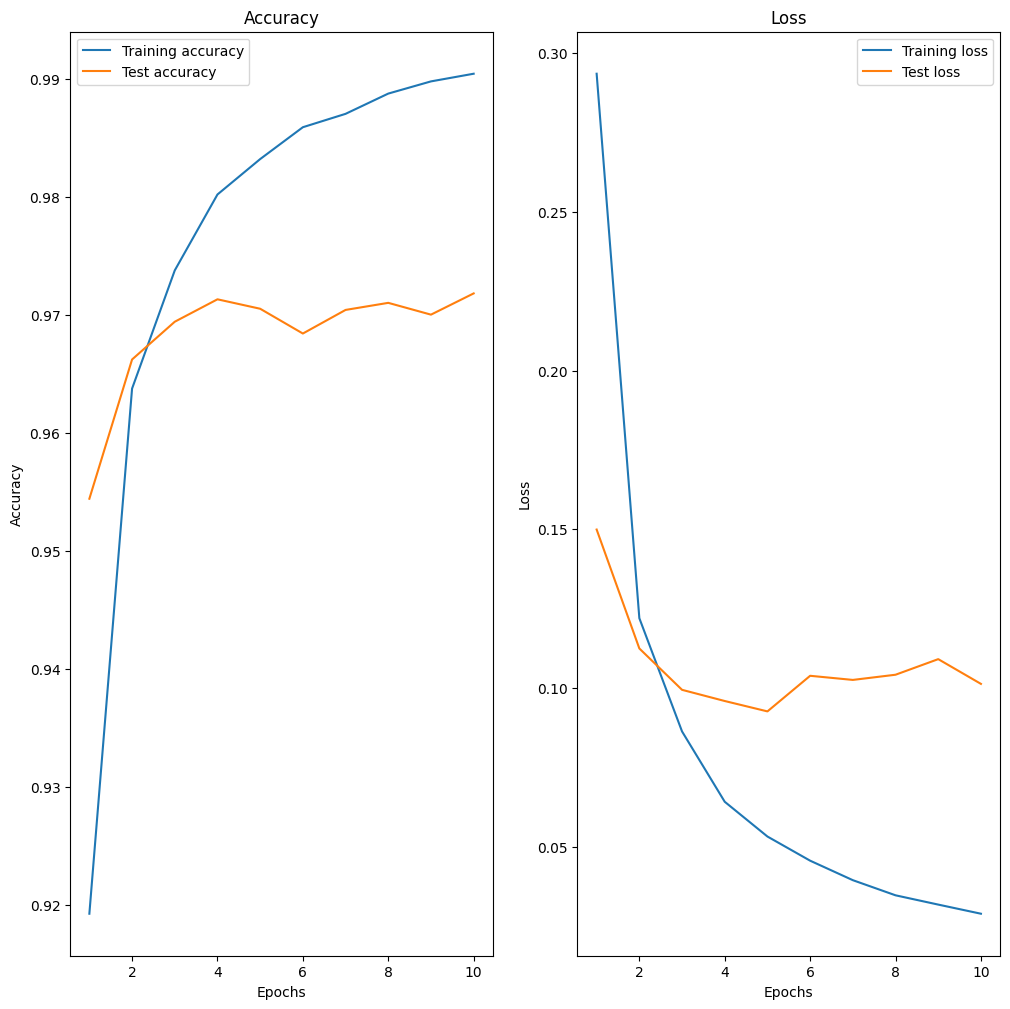

In [32]:
plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10)

We see the same for the neural network with Tanh activationfunction. From the epoch 5 onwards, the model seems to be overfitting since the test loss started to increase

**4. Neural Network with batch normalizaton**

An experiment of batch normalizaton for the Neural Network with ReLU activation. The batch normalizations were done between layers and just before the activation function.

In [36]:
class NN_relu_norm(nn.Module):
    def __init__(self):
        super(NN_relu_norm, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

nn_relu_norm = NN_relu_norm().to(device)
print(nn_relu_norm)

NN_relu_norm(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [37]:
# Optimizer: ADAM with learning rate = 0.001
optimizer3 = optim.Adam(nn_relu_norm.parameters(), lr=1e-3)

# train and test model
train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss = train_test_epoch(train_dataloader,
                                                                                                  test_dataloader,
                                                                                                  nn_relu_norm,
                                                                                                  loss_func,
                                                                                                  optimizer3,
                                                                                                  epochs=10,
                                                                                                  step_decay=False)

Epoch 1
--------------------------------
loss: 2.360871 [    0/60000]


loss: 0.388248 [ 6400/60000]
loss: 0.299039 [12800/60000]
loss: 0.192294 [19200/60000]
loss: 0.157338 [25600/60000]
loss: 0.326720 [32000/60000]
loss: 0.106038 [38400/60000]
loss: 0.295043 [44800/60000]
loss: 0.159784 [51200/60000]
loss: 0.164230 [57600/60000]
Train Error:
 Accuracy: 93.3%, Avg loss: 0.256903
Test Error:
 Accuracy: 96.2%, Avg loss: 0.123059
Epoch 2
--------------------------------
loss: 0.101703 [    0/60000]
loss: 0.134264 [ 6400/60000]
loss: 0.139745 [12800/60000]
loss: 0.093179 [19200/60000]
loss: 0.055829 [25600/60000]
loss: 0.249996 [32000/60000]
loss: 0.096942 [38400/60000]
loss: 0.191799 [44800/60000]
loss: 0.121007 [51200/60000]
loss: 0.064619 [57600/60000]
Train Error:
 Accuracy: 97.2%, Avg loss: 0.093343
Test Error:
 Accuracy: 96.9%, Avg loss: 0.099044
Epoch 3
--------------------------------
loss: 0.041156 [    0/60000]
loss: 0.089855 [ 6400/60000]
loss: 0.093170 [12800/60000]
loss: 0.046144 [19200/60000]
loss: 0.026757 [25600/60000]
loss: 0.118602 [32000/60

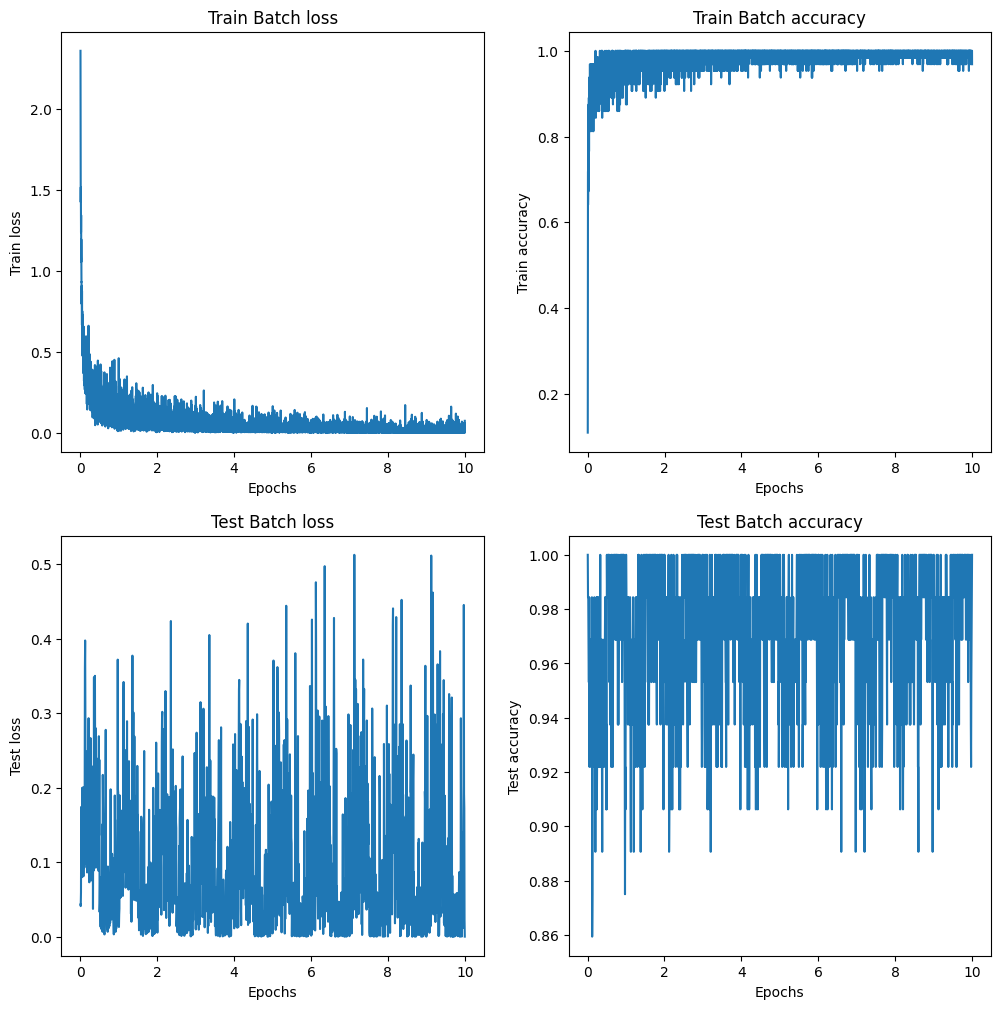

In [38]:
plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss)

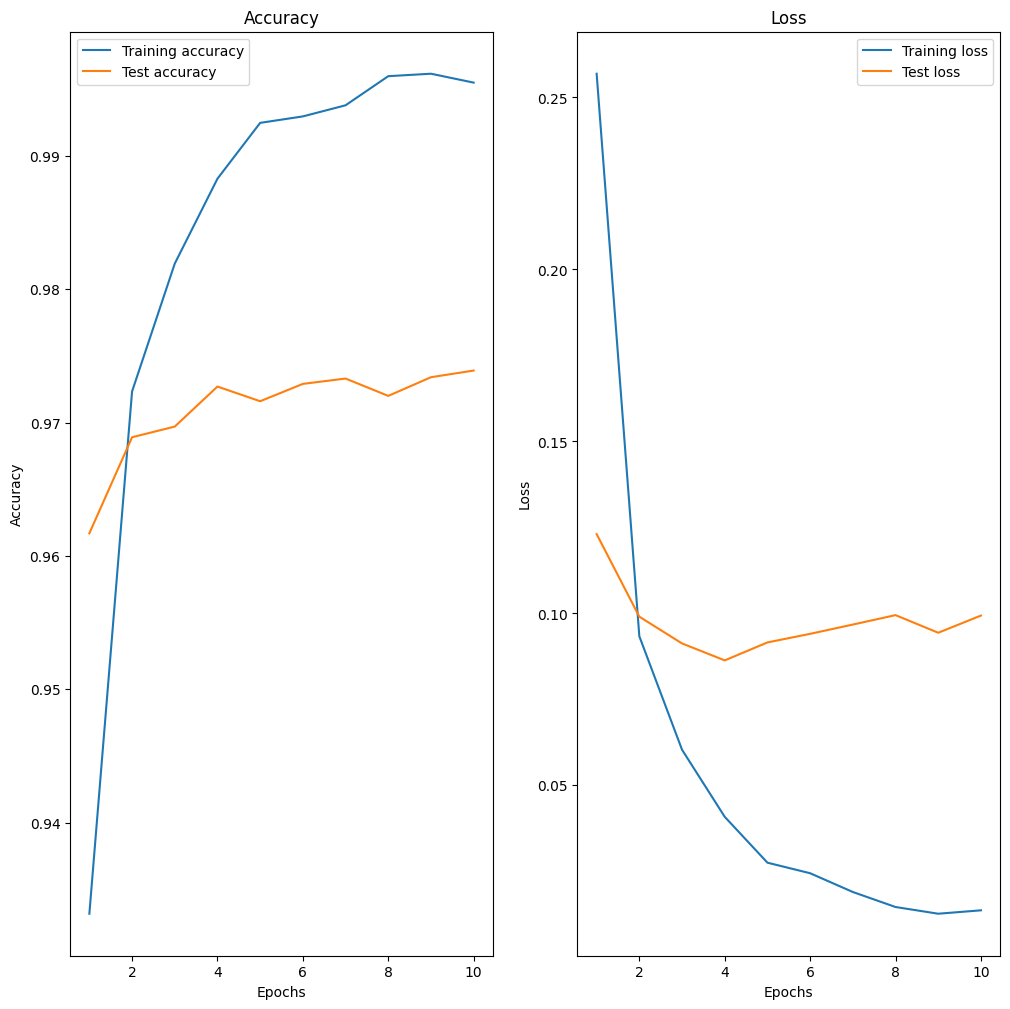

In [39]:
plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10)

The Batch Normalization improve the accuracy and seems to reduce the loss but it does not solve the overfitting problem from epoch 4 onwards (the loss increases)

**5. Neural Network with weights initialisation**

The weights $w$ were initialized with He initialisation ( $w = N(0,1)/\sqrt{\text{size}_{\text{input}}/2}$ ) for ReLU activation.

In [46]:
# Weight Initialisation function
def weights_He_init(m):
  if isinstance(m, nn.Linear):
    init.kaiming_normal_(m.weight)
    init.constant_(m.bias, 0)

In [48]:
class NN_relu_init(nn.Module):
    def __init__(self):
        super(NN_relu_init, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

nn_relu_init = NN_relu_init().to(device)
nn_relu_init.apply(weights_He_init)
print(nn_relu_init)

NN_relu_init(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [49]:
# Optimizer: ADAM with learning rate = 0.001
optimizer4 = optim.Adam(nn_relu_init.parameters(), lr=1e-3)

# train and test model
train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss = train_test_epoch(train_dataloader,
                                                                                                  test_dataloader,
                                                                                                  nn_relu_init,
                                                                                                  loss_func,
                                                                                                  optimizer4,
                                                                                                  epochs=10,
                                                                                                  step_decay=False)

Epoch 1
--------------------------------
loss: 3.013055 [    0/60000]


loss: 0.313003 [ 6400/60000]
loss: 0.205228 [12800/60000]
loss: 0.226029 [19200/60000]
loss: 0.159930 [25600/60000]
loss: 0.237268 [32000/60000]
loss: 0.128858 [38400/60000]
loss: 0.252663 [44800/60000]
loss: 0.240414 [51200/60000]
loss: 0.215729 [57600/60000]
Train Error:
 Accuracy: 92.0%, Avg loss: 0.264712
Test Error:
 Accuracy: 94.7%, Avg loss: 0.168433
Epoch 2
--------------------------------
loss: 0.111413 [    0/60000]
loss: 0.188426 [ 6400/60000]
loss: 0.125365 [12800/60000]
loss: 0.121533 [19200/60000]
loss: 0.083107 [25600/60000]
loss: 0.142541 [32000/60000]
loss: 0.131231 [38400/60000]
loss: 0.186831 [44800/60000]
loss: 0.160778 [51200/60000]
loss: 0.159993 [57600/60000]
Train Error:
 Accuracy: 96.4%, Avg loss: 0.116747
Test Error:
 Accuracy: 96.7%, Avg loss: 0.106711
Epoch 3
--------------------------------
loss: 0.050921 [    0/60000]
loss: 0.145181 [ 6400/60000]
loss: 0.122841 [12800/60000]
loss: 0.101096 [19200/60000]
loss: 0.069787 [25600/60000]
loss: 0.069524 [32000/60

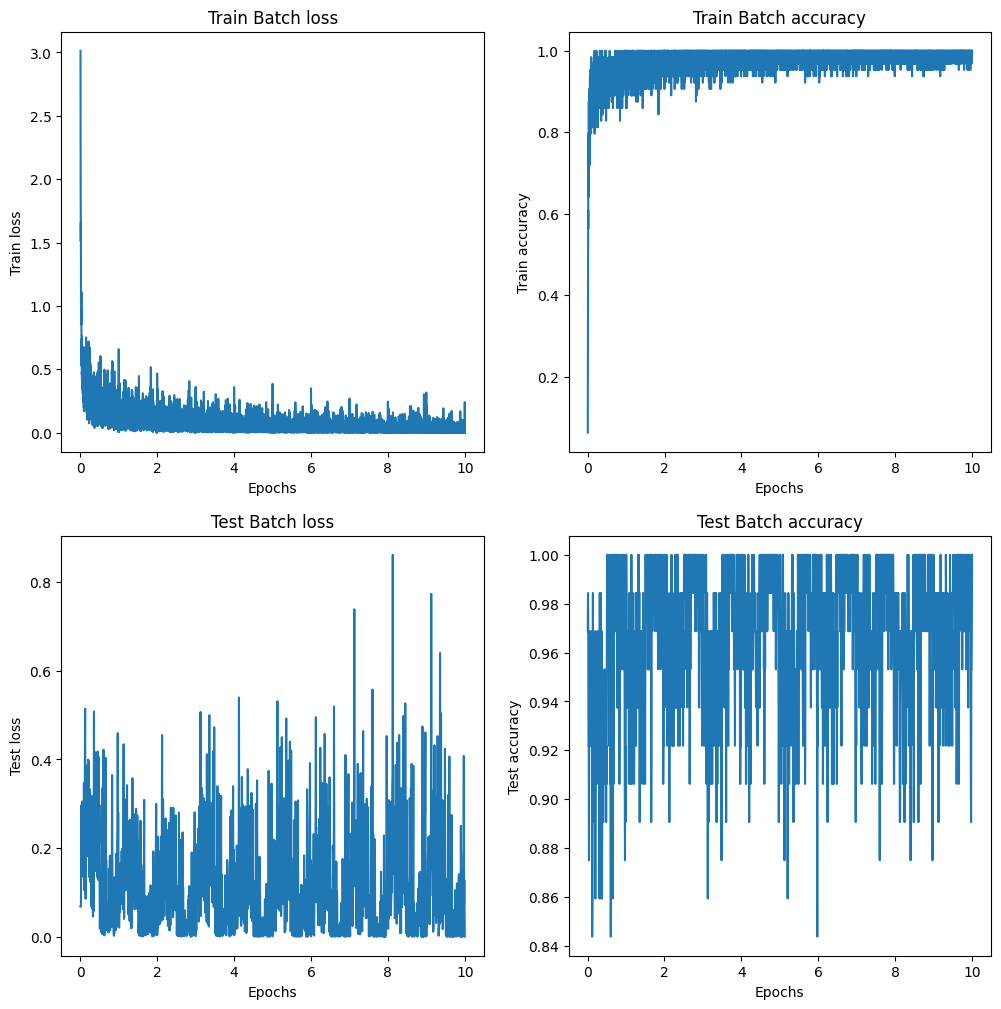

In [50]:
plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss)

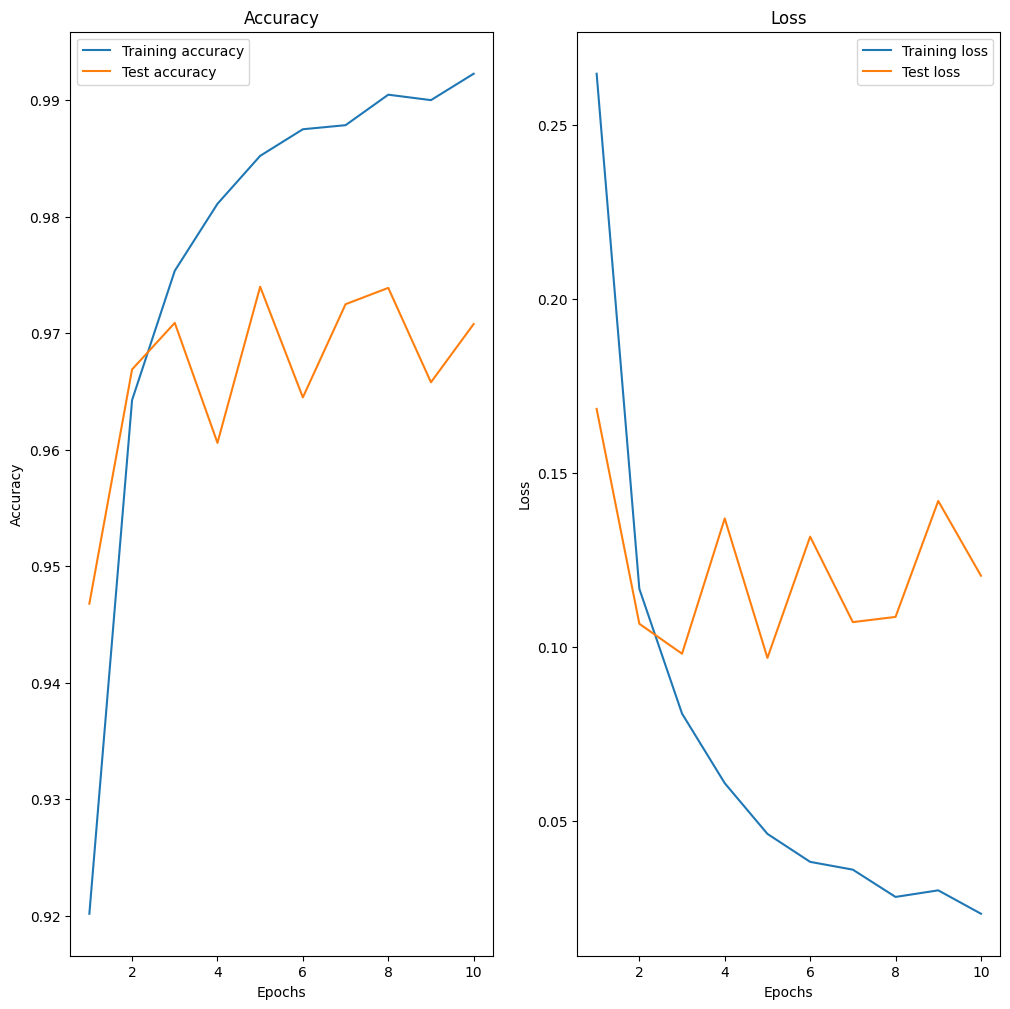

In [51]:
plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10)

The weight initialisation seems to not improve the test accuracy significantly. The test accuracy and test loss are not stable and the test loss tends to increase. This indicates the overfitting of the model 

**6. Neural Network with dropout**

Dropout was used for reducing overfitting with $p = 0.2$ for input layer and $p = 0.5$ for hidden layers

In [65]:
class NN_dropout(nn.Module):
    def __init__(self):
        super(NN_dropout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

nn_dropout = NN_dropout().to(device)
print(nn_dropout)

NN_dropout(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [66]:
# Optimizer: ADAM with learning rate = 0.001
optimizer5 = optim.Adam(nn_dropout.parameters(), lr=1e-3)

# train and test model
train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss = train_test_epoch(train_dataloader,
                                                                                                  test_dataloader,
                                                                                                  nn_dropout,
                                                                                                  loss_func,
                                                                                                  optimizer5,
                                                                                                  epochs=10,
                                                                                                  step_decay=False)

Epoch 1
--------------------------------
loss: 2.326179 [    0/60000]


loss: 0.682153 [ 6400/60000]
loss: 0.610556 [12800/60000]
loss: 0.580602 [19200/60000]
loss: 0.378869 [25600/60000]
loss: 0.525146 [32000/60000]
loss: 0.395405 [38400/60000]
loss: 0.632564 [44800/60000]
loss: 0.472167 [51200/60000]
loss: 0.529580 [57600/60000]
Train Error:
 Accuracy: 81.5%, Avg loss: 0.609398
Test Error:
 Accuracy: 93.6%, Avg loss: 0.212867
Epoch 2
--------------------------------
loss: 0.283492 [    0/60000]
loss: 0.313371 [ 6400/60000]
loss: 0.279074 [12800/60000]
loss: 0.316334 [19200/60000]
loss: 0.337152 [25600/60000]
loss: 0.453298 [32000/60000]
loss: 0.284016 [38400/60000]
loss: 0.326967 [44800/60000]
loss: 0.257609 [51200/60000]
loss: 0.359038 [57600/60000]
Train Error:
 Accuracy: 89.6%, Avg loss: 0.368787
Test Error:
 Accuracy: 94.8%, Avg loss: 0.169240
Epoch 3
--------------------------------
loss: 0.323927 [    0/60000]
loss: 0.393216 [ 6400/60000]
loss: 0.450647 [12800/60000]
loss: 0.570404 [19200/60000]
loss: 0.386357 [25600/60000]
loss: 0.443314 [32000/60

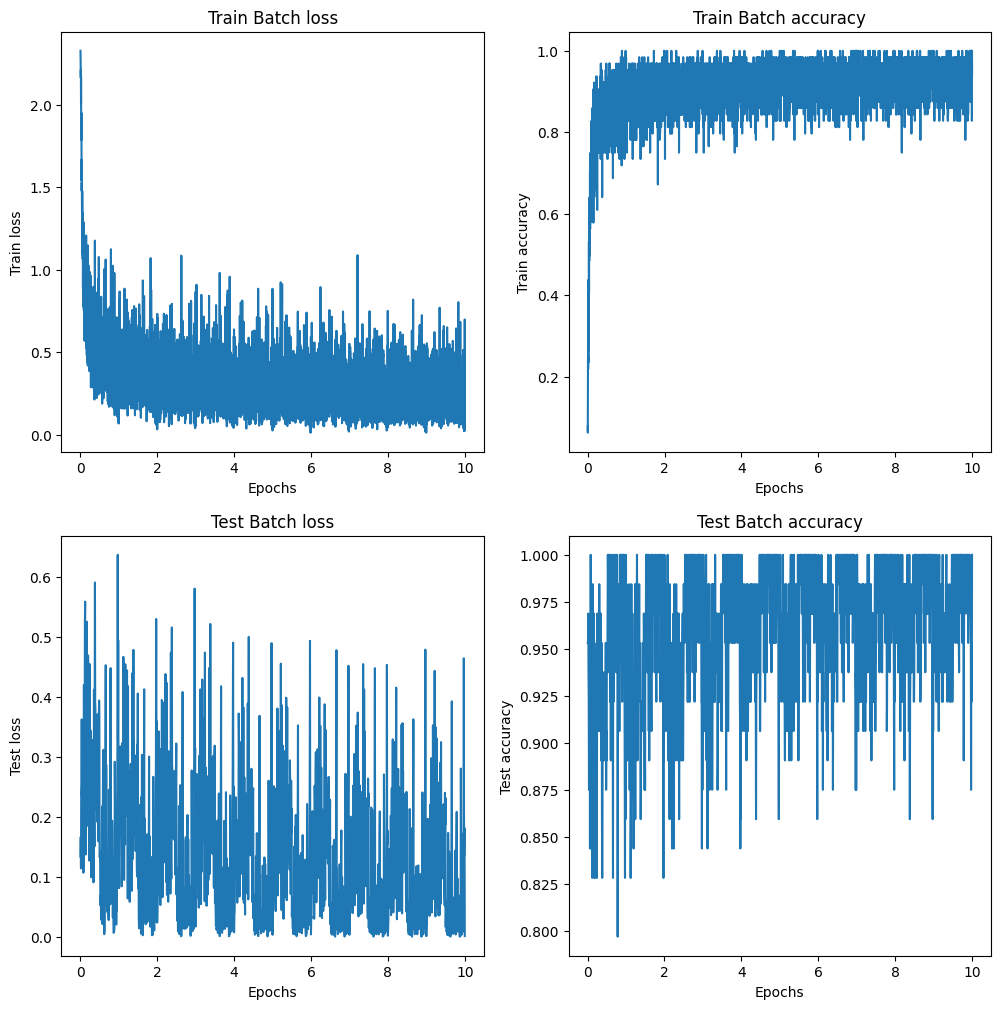

In [68]:
plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss)

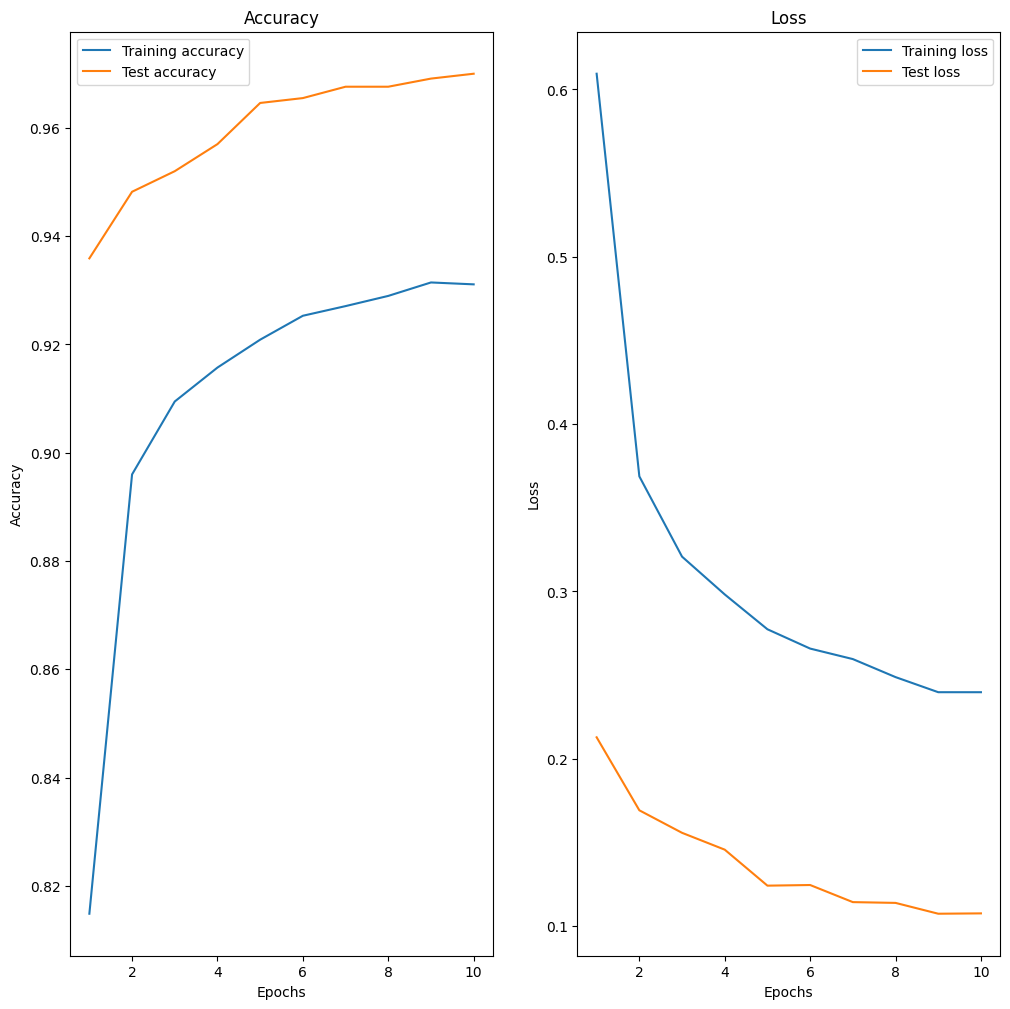

In [69]:
plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10)

The neural network have good test accuracy, the accuracy increases along with the increase of epochs and exceeded 97.0% in epoch 10. The dropout solved the overfitting problem of since the test loss decrease continually along with the increase of epochs (test loss = 0.107646 in epoch 10). 

In the graph, the test loss is lower than the train loss. This could be explained that the dropout deactivated certain neurons with probability $p$ during training process, it forces the network to learn many solutions to prevent overfitting. However, this will make the model more difficult to learn from training data so the performance on train data could be decreased (train accuracy decreases and train loss increases). The dropout only operated during training process and not in test process so the test loss could be lower than the train loss.

**7. Neural Network with weights initialisation, batch normalization and dropout**

In [58]:
class NN_all(nn.Module):
    def __init__(self):
        super(NN_all, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

nn_all = NN_all().to(device)
nn_all.apply(weights_He_init)
print(nn_all)

NN_all(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [59]:
# Optimizer: ADAM with learning rate = 0.001
optimizer6 = optim.Adam(nn_all.parameters(), lr=1e-3)

# train and test model
train_epoch, train_accuracy, train_loss, train_batch_accuracy, train_batch_loss, \
    test_epoch, test_accuracy, test_loss, test_batch_accuracy, test_batch_loss = train_test_epoch(train_dataloader,
                                                                                                  test_dataloader,
                                                                                                  nn_all,
                                                                                                  loss_func,
                                                                                                  optimizer6,
                                                                                                  epochs=10,
                                                                                                  step_decay=False)

Epoch 1
--------------------------------
loss: 2.906332 [    0/60000]


loss: 1.431037 [ 6400/60000]
loss: 0.991494 [12800/60000]
loss: 0.920093 [19200/60000]
loss: 0.790208 [25600/60000]
loss: 0.730651 [32000/60000]
loss: 0.693816 [38400/60000]
loss: 0.920972 [44800/60000]
loss: 0.518473 [51200/60000]
loss: 0.630955 [57600/60000]
Train Error:
 Accuracy: 74.4%, Avg loss: 0.816708
Test Error:
 Accuracy: 92.1%, Avg loss: 0.263408
Epoch 2
--------------------------------
loss: 0.589365 [    0/60000]
loss: 0.493655 [ 6400/60000]
loss: 0.582479 [12800/60000]
loss: 0.375580 [19200/60000]
loss: 0.494716 [25600/60000]
loss: 0.562695 [32000/60000]
loss: 0.409944 [38400/60000]
loss: 0.711982 [44800/60000]
loss: 0.534562 [51200/60000]
loss: 0.486912 [57600/60000]
Train Error:
 Accuracy: 85.8%, Avg loss: 0.480059
Test Error:
 Accuracy: 93.6%, Avg loss: 0.210293
Epoch 3
--------------------------------
loss: 0.283121 [    0/60000]
loss: 0.342837 [ 6400/60000]
loss: 0.423911 [12800/60000]
loss: 0.431819 [19200/60000]
loss: 0.413435 [25600/60000]
loss: 0.512778 [32000/60

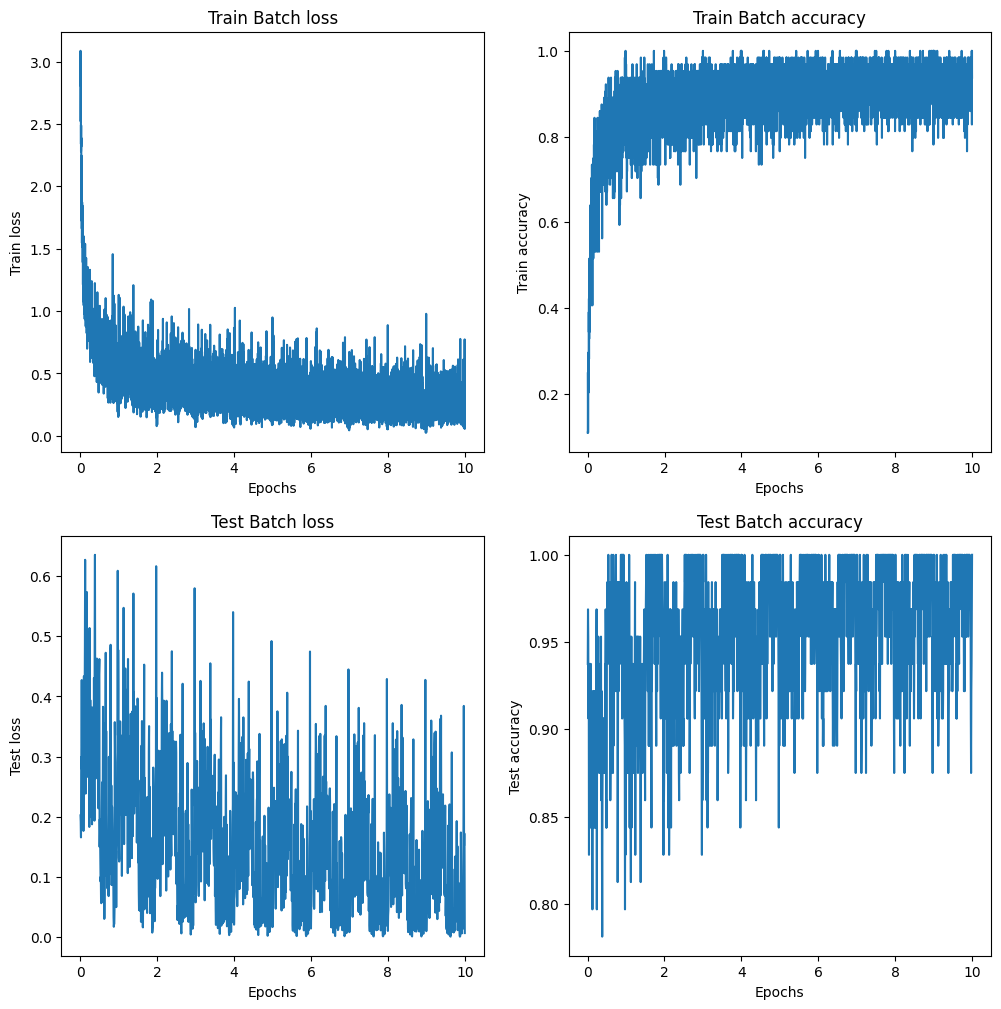

In [62]:
plot_fig1(train_epoch, train_batch_accuracy, train_batch_loss, test_epoch, test_batch_accuracy, test_batch_loss)

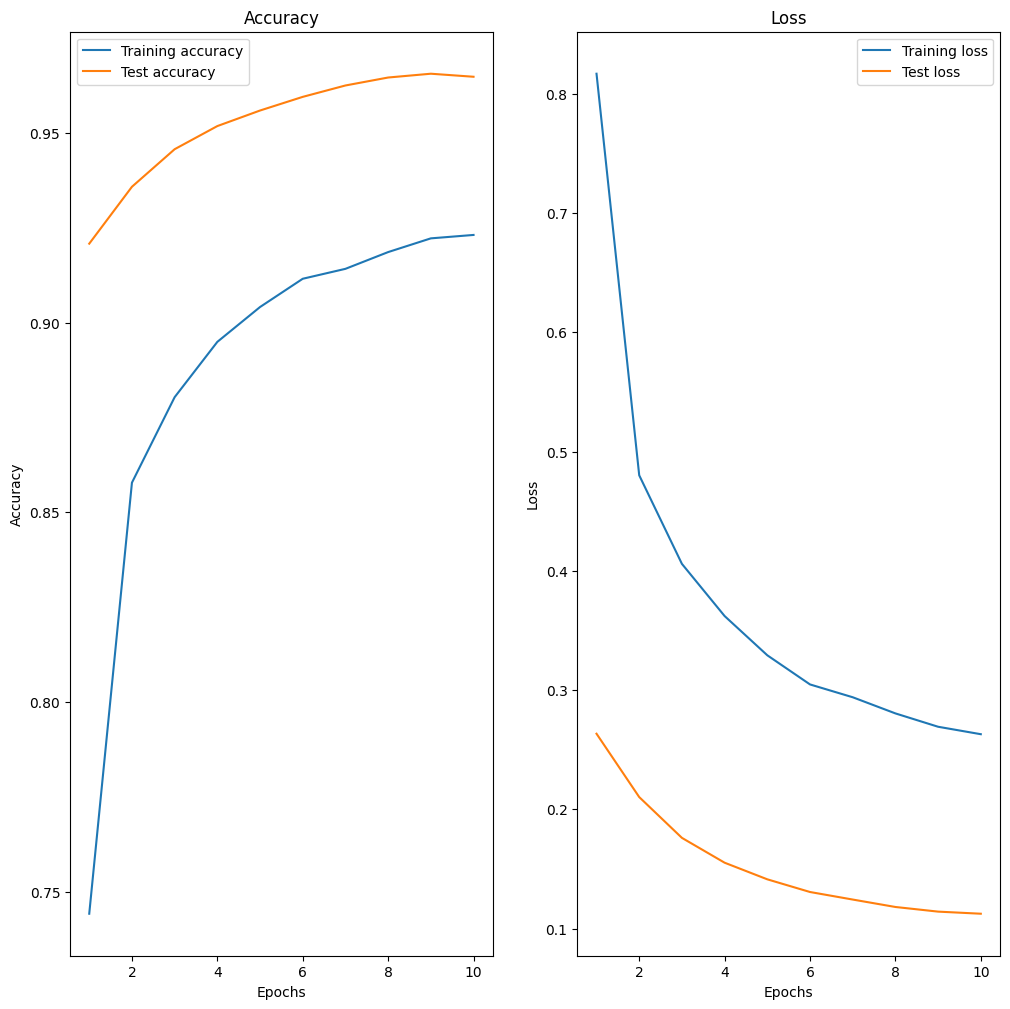

In [63]:
plot_fig2(train_accuracy, test_accuracy, train_loss, test_loss, epochs = 10)

The model is quite good with gradually increase of test accuracy (test accuracy = 96.5% in epoch 10) and decrease of test loss (test loss = 0.112502 in epoch 10). The dropout solved the overfitting problem. The test accuracy increases and test loss decreases not as fast as the neural network with only dropout above after 10 epochs.